<a href="https://colab.research.google.com/github/j-buss/wi-dpi-analysis/blob/development/blog/5_A_Geographic_Descriptive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Teacher Salary in Wisconsin - 5A - Blog - Geographic Pay Analysis

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from google.cloud import bigquery
import matplotlib

In [0]:
%matplotlib inline
plt.style.use('bmh')

In [5]:
import matplotlib.style as style
style.available

['grayscale',
 'fivethirtyeight',
 'seaborn-notebook',
 'classic',
 'seaborn',
 '_classic_test',
 'bmh',
 'seaborn-dark-palette',
 'seaborn-colorblind',
 'seaborn-whitegrid',
 'seaborn-white',
 'seaborn-dark',
 'seaborn-poster',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'seaborn-bright',
 'seaborn-muted',
 'seaborn-talk',
 'dark_background',
 'tableau-colorblind10',
 'seaborn-deep',
 'ggplot',
 'fast',
 'seaborn-pastel',
 'Solarize_Light2',
 'seaborn-paper']

In [0]:
style.use('fivethirtyeight')

### Functions

In [0]:
# To help with the pie charts later
def make_autopct(values):
  def my_autopct(pct):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return '{p:.2f}% \n({v:,d})'.format(p=pct,v=val)
  return my_autopct

### Processing

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
project_id='wi-dpi-010'
landing_dataset_name='landing'
refined_dataset_name='refined'
gold_dataset_name='gold'

In [0]:
bq_client = bigquery.Client(project=project_id)

### Cesa Summary

Let's add another layer to the analysis. We can look at differences by location. A number of initial questions come to mind very quickly.


1.   What is area with the highest average salary? What about the lowest?
2.   What is the area with the highest starting salary? What about the lowest?
3.   Are average salaries found in geographic groups?

Well, to start answering these questions let's bring to mind the geographic hiearchy...or rather how do we start at the top: State and work our way down to School District...or maybe even school.

Fortunately for us this topic is a fairly common one and the WI Department of Public Instruction has devised our first "layer" under a state. It is CESA.

And as any group of people we must refer to the acronyms! CESA is the "Cooperative Educational Service Agency". For our purposes it simply groups districts together. However, for more information you can consult the [WI DPI CESA](https://dpi.wi.gov/cesa) page.



Within the information we have already looked at there is a code showing the CESA number for an individual role. 

Now there are a few individuals who do work "across" CESA districts. However for this analysis we will set asside those individuals and stick with the vast majority (99.45%) of individuals who work in only one district. 

#### Average Salary by Cesa

In [0]:
# Group by CESA - [CESA_NUM, Avg_Salary, Count] - 
salary_analysis_by_cesa_sql ='''
SELECT
  Cesa_Num,
  Round(Avg(Salary),2) as Avg_Salary,
  count(research_ID) AS Count
FROM
  `wi-dpi-010.refined.2017_CESA_Analysis_level_01`
WHERE
  Pos_Cat_Flag = 'T'
GROUP BY
  Cesa_Num
ORDER BY 
  1

'''

First Year Teacher Salary by CESA

In [0]:
# Group by CESA - [CESA_NUM, Avg_Salary, Count]
salary_analysis_by_cesa_sql ='''
SELECT
  Cesa_Num,
  Round(Avg(Salary),2) as Avg_Salary,
  count(research_ID) AS Count
FROM
  `wi-dpi-010.refined.2017_CESA_Analysis_level_01`
WHERE
  Pos_Cat_Flag = 'T' and
  max_contract_total_experience < 1 and
  assignment_fte >= 1.0
GROUP BY
  Cesa_Num
ORDER BY 
  1

'''

In [0]:
sql = '''
SELECT
  Cesa_Num,
  Round(Avg(Salary),2) as Avg_Salary,
  count(research_ID) AS Count,
  Round(Avg(max_contract_total_experience),2) as experience,
  Round(Avg(age),2) as age,
  max_contract_days,
FROM
  {}.{}
WHERE
  Pos_Cat_Flag = 'T' and
  assignment_fte >= 1.0
GROUP BY
  Cesa_Num
  '''.format('refined','2017_geo_Analysis_level_01')

In [0]:
sql = '''
SELECT
  Cesa_Num,
  Round(Salary,2) as Salary,
  research_ID,
  Round(max_contract_total_experience,2) as experience,
  Round(age,2) as age,
  max_contract_days,
  assignment_fte
FROM
  {}.{}
WHERE
  Pos_Cat_Flag = 'T'
  '''.format('refined','2017_geo_Analysis_level_01')

In [38]:
geo_analysis_df = pd.read_gbq(sql, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [0]:
geo_analysis_df['contract_days_median'] = geo_analysis_df['max_contract_days'].median()
geo_analysis_df['contract_days_std'] = geo_analysis_df['max_contract_days'].std()

In [40]:
geo_analysis_df.head(5)

,Cesa_Num,Salary,research_ID,experience,age,max_contract_days,assignment_fte,contract_days_median,contract_days_std
0,1,4700.0,100910,7.0,19.0,191,0.1,190.0,11.942235
1,10,71000.0,95910,4.0,20.0,188,1.0,190.0,11.942235
2,1,4500.0,3999,0.5,21.0,93,0.5,190.0,11.942235
3,1,41311.0,160958,1.0,21.0,191,1.0,190.0,11.942235
4,7,4500.0,5845,1.0,21.0,92,0.5,190.0,11.942235


In [0]:
Cesa_Sum_All_df = geo_analysis_df.groupby('Cesa_Num') \
  .agg({'Salary':'mean', 'research_ID':'size', 'experience':'mean', 'age':'mean'}) \
  .rename(columns={'Salary':'Avg. Salary', 'research_ID':'Count of Individuals',\
                   'experience':'Avg. Experience','age':'Avg. Age'})

#df = df.groupby('source') \
#       .agg({'text':'size', 'sent':'mean'}) \
#       .rename(columns={'text':'count','sent':'mean_sent'}) \
#       .reset_index()

In [46]:
Cesa_Sum_All_df

,Avg. Salary,Count of Individuals,Avg. Experience,Avg. Age
Cesa_Num,,,,
1,59307.509874,16863,13.989000,42.003202
2,54057.697489,11907,13.736877,41.160998
3,50062.897389,1647,15.723437,42.290225
4,50333.724339,2913,14.161002,41.088912
5,52059.911561,3901,14.766342,41.917457
6,54423.389558,7144,14.564740,41.159994
7,54412.092048,6388,14.584220,41.642611
8,49266.822581,1612,14.673077,42.605459
9,54665.723869,2564,14.717044,42.047972


In [0]:
for x,y in zip(xs,ys):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [115]:
for k, v in Cesa_Sum_All_df.iterrows():
    print ( k, v['Avg. Salary'], v['Avg. Experience'])

1 59307.50987368796 13.988999584889996
2 54057.697488872094 13.736877467036198
3 50062.89738919247 15.723436551305404
4 50333.72433916924 14.161002403020941
5 52059.91156113817 14.766341963599077
6 54423.38955767077 14.564739641657335
7 54412.09204758923 14.58422041327489
8 49266.82258064516 14.673076923076923
9 54665.72386895476 14.71704368174727
10 50481.01356802347 14.300880088008801
11 52347.80424799082 14.5097588978186
12 51273.62227805695 14.775544388609715


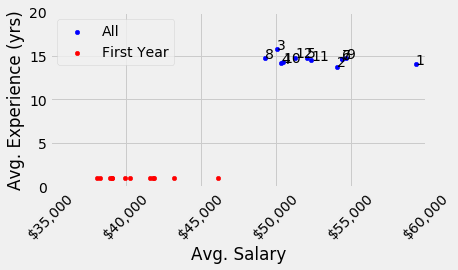

In [117]:
fig, ax1 = plt.subplots(nrows=1, ncols=1,
                           figsize=(6,3))

currency_fmt = '${x:,.0f}'
currency_tick = mtick.StrMethodFormatter(currency_fmt)

#fig.text(-.05, 0.5, "Cities", va='center', rotation='vertical', size=BIGGER_SIZE, weight='bold')



ax = Cesa_Sum_All_df.plot.scatter(x="Avg. Salary", y="Avg. Experience", ax=ax1,color='b', label='All')
ax = Cesa_Sum_FirstYear_df.plot.scatter(x="Avg. Salary", y="Avg. Experience", ax=ax1, color='r', label='First Year')
ax1.set_ylabel('Avg. Experience (yrs)')
ax1.xaxis.set_major_formatter(currency_tick) 
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0,20)

ax1.set_xlim(35000, 60000)
#Cesa_Sum_All_df['Avg.Salary','Avg. Experience','Cesa_num'].apply(lambda x: ax.text(*x),axis=1);

for k, v in Cesa_Sum_All_df.iterrows():
    ax.text(v['Avg. Salary'], v['Avg. Experience'], k)

AttributeError: ignored

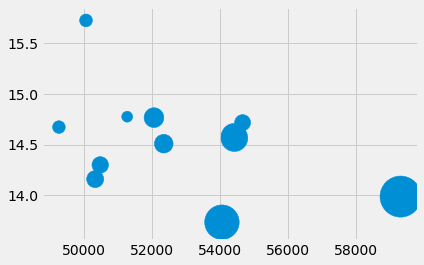

In [45]:
plt.scatter(Cesa_Sum_All_df['Avg. Salary'],Cesa_Sum_All_df['Avg. Experience'],s=Cesa_Sum_All_df['Count of Individuals']/10)

#scat_graph.('SCATTER')
#scat_graph.tick_params(axis = 'both', labelsize=9)
plt.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#plt.get_xaxis().set_major_formatter(
#  matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#plt.get_yaxis().set_major_formatter(
#  matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [0]:
geo_analysis_firstyear_df = geo_analysis_df[
    (geo_analysis_df['experience']<= 1.0) & \
    (geo_analysis_df['assignment_fte']>=1.0) & \
    (geo_analysis_df['max_contract_days'] >= geo_analysis_df['contract_days_median']-2*geo_analysis_df['contract_days_std']) \
]

In [0]:
Cesa_Sum_FirstYear_df = geo_analysis_firstyear_df.groupby('Cesa_Num') \
  .agg({'Salary':'mean', 'research_ID':'size', 'experience':'mean', 'age':'mean'}) \
  .rename(columns={'Salary':'Avg. Salary', 'research_ID':'Count of Individuals',\
                   'experience':'Avg. Experience','age':'Avg. Age'})

In [68]:
Cesa_Sum_FirstYear_df

,Avg. Salary,Count of Individuals,Avg. Experience,Avg. Age
Cesa_Num,,,,
1,46157.836611,661,0.989410,30.373676
2,43211.625229,547,0.971664,30.120658
3,38936.373494,83,0.981928,27.771084
4,38302.849206,126,1.000000,27.158730
5,40277.655556,180,0.963889,29.211111
6,41804.308300,253,1.000000,29.418972
7,41642.736000,250,0.992000,29.704000
8,38078.833333,66,1.000000,31.060606
9,41857.508621,116,0.956897,29.879310


Need to load the districts / CESA information https://apps4.dpi.wi.gov/SchoolDirectory/Search/PublicDistrictsSearch

### Map Salary Ranges

So the previous analysis is good. However...yeah it is a bit lacking. I mean it feels like we need to bring the whole visual aspect into the analysis. I mean there is lots of good data in a list with averages, but let's add the whole mapping piece.

If we want to add the map components we can consult the Open GEO Data for Wisconsin: http://geodata.wisc.edu/opengeoportal/
The site has a nice interface in which to search for specific geographic information systems (GIS) data.

#### By Cesa

### District Summary

#### Average Salary by District

In [0]:
# Ascending - Top 10

In [0]:
# Descending - Top 10

Let's just map the CESA Areas...

In [0]:
# CODE FOR MAP

Ok. Getting there. Now let's bring in the color coding based on the average salary.

In [0]:
# Color based on Average Salary

In [0]:
# Color based on 1st year Salary

#### By District

In [0]:
# Color based on Average Salary

In [0]:
# Color based on 1st year Salary